# 任务目的是通过机器学习算法找出哪些特征与暴力犯罪率之间存在显著的关联关系。

# 1.数据简介
数据集：社区与犯罪 (Communities and Crime) 数据集 [来源: UCI]。
OpenML ID: 531

简介：该数据集汇编了来自美国不同社区的社会经济、人口统计和执法数据。它经常被用于预测犯罪率。

目标变量 (y)：ViolentCrimesPerPop（每 10 万人中的暴力犯罪率）

特征 (X)：数据集包含约 127 个特征，其中许多是非预测性的标识符（如 state, communityName）。移除这些标识符，保留约 100 个预测性特征，例如：

population (人口)

medIncome (收入中位数)

PctPopUnderPov (贫困线以下人口百分比)

PctLess9thGrade (受教育程度低于 9 年级的人口百分比)

NumInShelters (收容所中的人数)

PolicPerPop (每 10 万人中的警官人数)


# 2.实现过程

1.Predictability (预测性)

数据清洗：加载数据，将 '?' 标记替换为 np.nan。移除所有非预测性特征（如标识符）

数据处理：缺失值：由于缺失值非常普遍，使用SimpleImputer以中位数填充所有特征的缺失值。

标准化：所有特征都将通过StandardScaler进行标准化，这是Lasso模型所必需的。

模型与评估：将数据分为训练集(80%)和测试集(20%)。使用LassoCV（带5折交叉验证）在训练集上寻找最佳的正则化参数。在测试集上评估模型的预测性能，使用 R^2作为指标。

2.Computability (可计算性)：

Lasso（通过坐标下降法求解）是一种计算效率极高的算法，即使面对数万特征也能快速求解。

规模：该数据集约 1994 个样本和 100 个特征，对于现代计算机来说规模很小。

3.Stability(稳定性)

稳定性是本分析的核心。评估“特征选择”这一结果在面对“数据扰动”时的稳定性。

稳定性目标：由LassoCV模型算法在数据上选出的非零系数特征集。

扰动：采用 Bootstrap（自助法）。这能模拟“如果我们去了相似但略有不同的社区收集数据”这一情景。

稳定性分析：在训练集上重复进行100次Bootstrap采样。在每一次Bootstrap采样数据上，都运行一个完整的 LassoCV 流程。记录每次被选中的特征。最后统计每个特征在 100 次实验中被选中的频率。

已从 UCI URL 成功加载数据。
移除了 0 行 (因目标变量缺失)。
数据加载完成。目标: ViolentCrimesPerPop。使用的预测特征数: 122

--- (P) 预测性评估 ---
正在训练 LassoCV 模型以评估预测性...
预测性 (R^2) - 测试集: 0.6380

--- (S) 稳定性分析 ---
正在执行 100 次 Bootstrap 扰动...
  Bootstrap 迭代 10/100
  Bootstrap 迭代 20/100
  Bootstrap 迭代 30/100
  Bootstrap 迭代 40/100
  Bootstrap 迭代 50/100
  Bootstrap 迭代 60/100
  Bootstrap 迭代 70/100
  Bootstrap 迭代 80/100
  Bootstrap 迭代 90/100
  Bootstrap 迭代 100/100
稳定性分析完成。

--- 结果报告 ---

--- (P) 预测性 R^2 (测试集) ---
0.6380

--- (S) Top 20 稳定特征 (共 100 次扰动) ---
                  Feature  SelectionFrequency
61         PctVacMore6Mos                 100
9                pctUrban                 100
42               PctIlleg                 100
33         MalePctDivorce                 100
1            racepctblack                 100
71  MedOwnCostPctIncNoMtg                 100
13             pctWInvInc                 100
73              NumStreet                 100
69      MedRentPctHousInc                  99
66               RentLowQ   

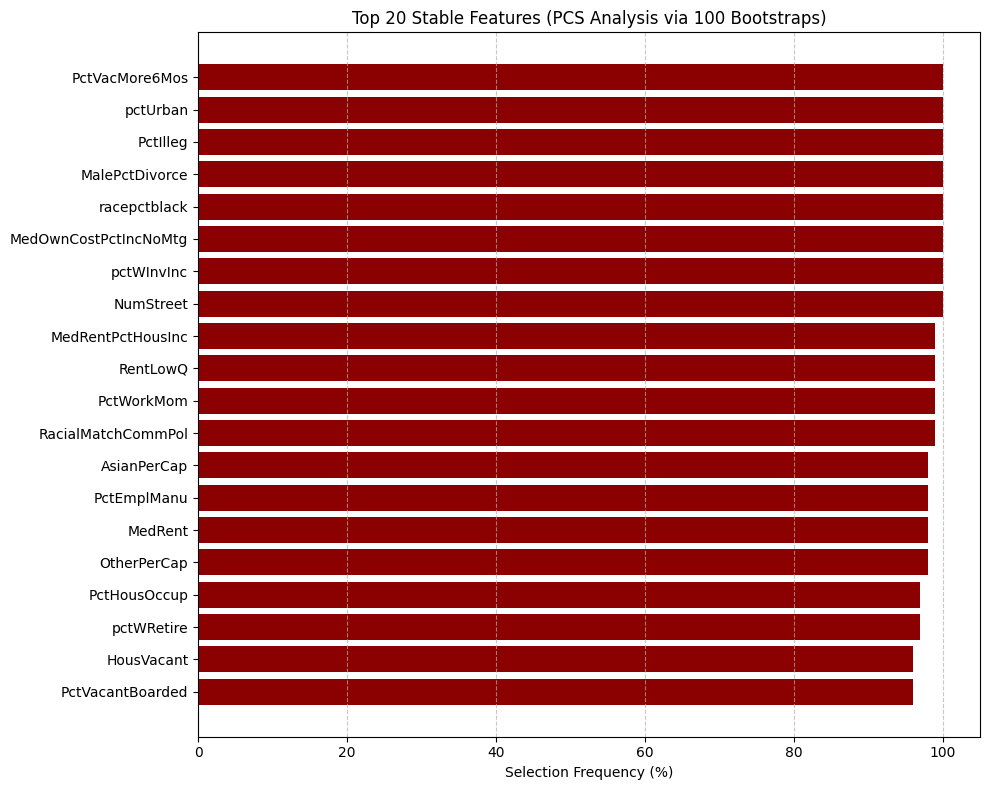

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from sklearn.utils import resample
from collections import defaultdict
import warnings
import ssl

# 忽略警告信息
warnings.filterwarnings('ignore')

# 解决 SSL 证书问题 (有时在访问 https 资源时需要)
ssl._create_default_https_context = ssl._create_unverified_context

# --- 1. 数据加载与准备 ---

data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data"

# 手动提供 128 个列名 (来自 communities.names)
column_names = [
    'state', 'county', 'community', 'communityName', 'fold', 'population', 
    'householdsize', 'racepctblack', 'racePctWhite', 'racePctAsian', 
    'racePctHisp', 'agePct12t21', 'agePct12t29', 'agePct16t24', 'agePct65up', 
    'numbUrban', 'pctUrban', 'medIncome', 'pctWWage', 'pctWFarmSelf', 
    'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'medFamInc', 
    'perCapInc', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 
    'OtherPerCap', 'HispPerCap', 'NumUnderPov', 'PctPopUnderPov', 'PctLess9thGrade', 
    'PctNotHSGrad', 'PctBSorMore', 'PctUnemployed', 'PctEmploy', 'PctEmplManu', 
    'PctEmplProfServ', 'PctOccupManu', 'PctOccupMgmtProf', 'MalePctDivorce', 
    'MalePctNevMarr', 'FemalePctDiv', 'TotalPctDiv', 'PersPerFam', 'PctFam2Par', 
    'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMomYoungKids', 
    'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRecent', 
    'PctImmigRec5', 'PctImmigRec8', 'PctImmigRec10', 'PctRecentImmig', 
    'PctRecImmig5', 'PctRecImmig8', 'PctRecImmig10', 'PctSpeakEnglOnly', 
    'PctNotSpeakEnglWell', 'PctLargHouseFam', 'PctLargHouseOccup', 
    'PersPerOccupHous', 'PersPerOwnOccHous', 'PersPerRentOccHous', 
    'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'MedNumBR', 
    'HousVacant', 'PctHousOccup', 'PctHousOwnOcc', 'PctVacantBoarded', 
    'PctVacMore6Mos', 'MedYrHousBuilt', 'PctHousNoPhone', 'PctWOFullPlumb', 
    'OwnOccLowQuart', 'OwnOccMedVal', 'OwnOccHiQuart', 'RentLowQ', 'RentMedian', 
    'RentHighQ', 'MedRent', 'MedRentPctHousInc', 'MedOwnCostPctInc', 
    'MedOwnCostPctIncNoMtg', 'NumInShelters', 'NumStreet', 'PctForeignBorn', 
    'PctBornSameState', 'PctSameHouse85', 'PctSameCity85', 'PctSameState85', 
    'LemasSwornFT', 'LemasSwFTPerPop', 'LemasSwFTFieldOps', 'LemasSwFTFieldPerPop', 
    'LemasTotalReq', 'LemasTotReqPerPop', 'PolicReqPerPop', 'PolicPerPop', 
    'RacialMatchCommPol', 'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp', 
    'PctPolicAsian', 'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz', 
    'PolicAveOTWorked', 'LandArea', 'PopDens', 'PctUsePubTrans', 'PolicCars', 
    'PolicOperBudg', 'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 'LemasPctOfficDrugUn', 
    'PolicBudgPerPop', 'ViolentCrimesPerPop'
]

try:
    # 使用 na_values='?' 来正确处理缺失值
    df = pd.read_csv(data_url, header=None, names=column_names, na_values='?')
    print("已从 UCI URL 成功加载数据。")
except Exception as e:
    print(f"从 URL 加载数据失败: {e}")
    print("请检查您的网络连接是否可以访问 'archive.ics.uci.edu'。")
    exit() # 如果加载失败，则停止

TARGET = 'ViolentCrimesPerPop'

# 移除 y 中的缺失值 (目标变量缺失的行必须丢弃)
y = pd.to_numeric(df[TARGET], errors='coerce')
valid_indices = y.notna()
y = y[valid_indices]
# 仅保留 y 中有效的行
df_filtered = df.loc[valid_indices].reset_index(drop=True)
y = y.reset_index(drop=True) # 同样重置 y 的索引

print(f"移除了 {len(df) - len(df_filtered)} 行 (因目标变量缺失)。")

# 这5个是非预测性特征
NON_PREDICTIVE_COLS = ['state', 'county', 'community', 'communityName', 'fold']

# 从过滤后的 df 中创建 X
X = df_filtered.drop([TARGET] + NON_PREDICTIVE_COLS, axis=1)

# 获取所有预测性特征的列名（现在都是数值型）
numeric_features = X.columns.tolist()
print(f"数据加载完成。目标: {TARGET}。使用的预测特征数: {len(numeric_features)}")

# --- 2. 构建数据预处理管道 (Pipeline) ---
# (此部分及之后代码与之前相同，是正确的 PCS 流程)

# 数值特征处理：中位数插补 + 标准化
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 使用 ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ],
    remainder='passthrough'
)

# --- 3. (P) 预测性评估 ---
print("\n--- (P) 预测性评估 ---")

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 定义交叉验证策略
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

# 创建一个包含预处理和 LassoCV 的完整管道
lasso_cv_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LassoCV(cv=cv_strategy, random_state=42, max_iter=2000, n_jobs=-1, tol=0.001))
])

# 训练模型
print("正在训练 LassoCV 模型以评估预测性...")
lasso_cv_pipeline.fit(X_train, y_train)

# 在测试集上评估
y_pred = lasso_cv_pipeline.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

print(f"预测性 (R^2) - 测试集: {test_r2:.4f}")

# --- 4. (S) 稳定性分析 (通过 Bootstrap) ---
print("\n--- (S) 稳定性分析 ---")

N_BOOTSTRAPS = 100  # 扰动次数
stability_target_counts = defaultdict(int)
n_samples = X_train.shape[0]

print(f"正在执行 {N_BOOTSTRAPS} 次 Bootstrap 扰动...")

for i in range(N_BOOTSTRAPS):
    if (i + 1) % 10 == 0:
        print(f"  Bootstrap 迭代 {i + 1}/{N_BOOTSTRAPS}")

    # 1. 数据扰动 (Bootstrap resampling)
    X_boot, y_boot = resample(X_train, y_train, n_samples=n_samples, random_state=i)

    # 2. 重新训练模型
    boot_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', LassoCV(cv=cv_strategy, random_state=i, max_iter=1000, n_jobs=-1, tol=0.001))
    ])
    
    boot_pipeline.fit(X_boot, y_boot)

    # 3. 提取稳定性目标 (选中的特征)
    model = boot_pipeline.named_steps['model']
    feature_names = numeric_features

    selected_indices = np.where(np.abs(model.coef_) > 1e-6)[0]
    
    for idx in selected_indices:
        stability_target_counts[feature_names[idx]] += 1

print("稳定性分析完成。")

# --- 5. 结果可视化 ---
print("\n--- 结果报告 ---")

# 转换字典为 DataFrame 以便排序
stability_df = pd.DataFrame(
    list(stability_target_counts.items()),
    columns=['Feature', 'SelectionFrequency']
).sort_values(by='SelectionFrequency', ascending=False)

# 过滤掉频率过低的特征，只显示 Top N
TOP_N_FEATURES = 20
stable_features = stability_df.head(TOP_N_FEATURES)

print(f"\n--- (P) 预测性 R^2 (测试集) ---")
print(f"{test_r2:.4f}")

print(f"\n--- (S) Top {TOP_N_FEATURES} 稳定特征 (共 {N_BOOTSTRAPS} 次扰动) ---")
print(stable_features.to_string())

# 绘制条形图
plt.figure(figsize=(10, 8))
plt.barh(
    stable_features['Feature'],
    stable_features['SelectionFrequency'] / N_BOOTSTRAPS * 100,
    color='darkred'
)
plt.xlabel('Selection Frequency (%)')
plt.title(f'Top {TOP_N_FEATURES} Stable Features (PCS Analysis via {N_BOOTSTRAPS} Bootstraps)')
plt.gca().invert_yaxis()  # 将最稳定的特征放在顶部
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
print("\n正在生成稳定性图表...")
plt.show()

# 3.结果分析
1.预测性：LassoCV模型在测试集（未见过的数据）上取得了63.8%的R^2。

分析: 对于一个像“社区犯罪率”这样复杂的社会科学问题，这是一个**非常强**的预测结果。这表明模型已经通过了“现实检验” ，它所学习到的模式是真实有效的，而不是随机噪声。因此，有充分的理由继续分析它所选择的特征。

2.稳定性: 稳定性图表显示了 Top 20 个最稳定的特征。

分析:在 100 次 Bootstrap 扰动中，排名最高的 20 个特征中的每一个，其被选中的频率都高达 96% 或更高。模型是从 122 个特征中进行选择的。稳定性分析表明，即使数据被反复扰动，LassoCV 模型也极其一致地认为这 20 个特征是不可或缺的。在这里，模型表现出了真正的稀疏稳定性——它清晰地将一小部分特征（这20个）与其余 100 多个特征区分开来。因此我们可以高度信任这些被选中的特征。它们不是由于数据随机性或共线性而被“偶然”选中的假发现。

3.一个“真实”的发现必须同时具备预测性 (P) 和稳定性 (S)。像 PctIlleg (非婚生子女)、MalePctDivorce (男性离婚率)、racepctblack (非裔美国人比例)、PctVacMore6Mos (房屋空置超6个月) 和 pctUrban (城镇人口) 这样的特征是预测暴力犯罪率的核心驱动因素。如果我们只运行一次Lasso，我们可能会得到一个包含 25 个特征的列表。我们无从知晓这25个特征是都重要，还是其中15个只是因为与另外10个真正稳定的特征高度相关而被偶然选入。通过本次分析，有大约 20 个特征是“中流砥柱”，无论数据如何波动，它们几乎总被选中。

